## Testing Grad-CAM in other architectures

In [ ]:
import copy
import time
import itertools

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from tqdm import tqdm
import ssl
from PIL import Image, ImageOps, ImageFilter
import random

import matplotlib.pyplot as plt  
%matplotlib inline

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from skimage import io
import cv2
import skimage.transform
import os

if not torch.cuda.is_available():
    raise Exception("You should enable GPU in the runtime menu.")
device = torch.device("cuda:0")

In [2]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# use the ImageNet transformation
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform2 = transforms.Compose(
    [transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
'''
# define a 1 image dataset
dataset = datasets.ImageFolder(root='./Test_CAM/data', transform=transform2)

# define the dataloader to load that single image
testimg = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1, num_workers=2)
'''


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


We can compute the gradients in PyTorch, using the .backward() method called on a torch.Tensor . This is exactly what I am going to do: I am going to call backward() on the most probable logit, which I obtain by performing the forward pass of the image through the network. However, PyTorch only caches the gradients of the leaf nodes in the computational graph, such as weights, biases and other parameters. The gradients of the output with respect to the activations are merely intermediate values and are discarded as soon as the gradient propagates through them on the way back.




In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.5)
        )

        self.mlp = nn.Sequential(
            nn.Linear(8 * 8 * 64, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        self.softmax = nn.LogSoftmax(-1)

    def forward(self, x):
        # TODO
        x = self.conv_layers(x)
        x = x.flatten(start_dim=1)
        x = self.mlp(x)
        label = self.softmax(x)
        return label, x


model = Net()
model.to(device)
model

Net(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
  )
  (mlp): Sequential(
    (0): Linear(in_features=4096, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (softmax): LogSoftmax(dim=-1)
)

In [4]:
model.conv_layers[:10]

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Dropout(p=0.5, inplace=False)
  (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
)

In [5]:
class Net_CAM(nn.Module):
    def __init__(self, Net):
        super(Net_CAM, self).__init__()

        # get the pretrained VGG19 network
        # self.vgg = vgg19(pretrained=True)
        self.net = Net

        # disect the network to access its last convolutional layer
        self.features_conv = self.net.conv_layers[:10]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.net.mlp
        
        # placeholder for the gradients
        self.gradients = None

        self.softmax = nn.LogSoftmax(-1)
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        #x = x.view((1, -1))
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        label = self.softmax(x)
        return label, x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

**Train the model**

In [6]:
net = Net().to(device)
model = Net_CAM(net).to(device)
model

Net_CAM(
  (net): Net(
    (conv_layers): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.5, inplace=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Dropout(p=0.5, inplace=False)
    )
    (mlp): Sequential(
      (0): Linear(in_features=4096, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=10, bias=True)
    )
    (softmax): LogSoftmax(dim=-1)
  )
  (features_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), pad

In [7]:
criterion = F.nll_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

t = time.time()
model.train()
epochs = 5
for epoch in range(epochs):  # loop over the dataset multiple times

    for i, (inputs, labels) in enumerate(trainloader):
        # get the inputs to gpu; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)

        # forward + backward + optimize
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print statistics
        if i % 300 == 299:    # print every 300 mini-batches
            print(f"Epoch {epoch+1}/{epochs} [{i+1}/{len(trainloader)}] loss: {loss.item():.2f}")

print('Finished Training')
print(f"Time: {(time.time() - t):.1f}s")

Epoch 1/5 [300/1563] loss: 1.62
Epoch 1/5 [600/1563] loss: 1.63
Epoch 1/5 [900/1563] loss: 1.33
Epoch 1/5 [1200/1563] loss: 1.36
Epoch 1/5 [1500/1563] loss: 0.81
Epoch 2/5 [300/1563] loss: 1.08
Epoch 2/5 [600/1563] loss: 1.17
Epoch 2/5 [900/1563] loss: 1.41
Epoch 2/5 [1200/1563] loss: 1.10
Epoch 2/5 [1500/1563] loss: 0.84
Epoch 3/5 [300/1563] loss: 0.77
Epoch 3/5 [600/1563] loss: 0.84
Epoch 3/5 [900/1563] loss: 1.11
Epoch 3/5 [1200/1563] loss: 0.75
Epoch 3/5 [1500/1563] loss: 1.04
Epoch 4/5 [300/1563] loss: 1.13
Epoch 4/5 [600/1563] loss: 0.63
Epoch 4/5 [900/1563] loss: 1.04
Epoch 4/5 [1200/1563] loss: 0.63
Epoch 4/5 [1500/1563] loss: 0.47
Epoch 5/5 [300/1563] loss: 0.46
Epoch 5/5 [600/1563] loss: 0.83
Epoch 5/5 [900/1563] loss: 0.97
Epoch 5/5 [1200/1563] loss: 0.63
Epoch 5/5 [1500/1563] loss: 0.80
Finished Training
Time: 130.6s


In [8]:
correct = 0
total = 0
model.eval()
for inputs, labels in testloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, _ = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the 10000 test images: {correct / total*100:.1f}%")

Accuracy of the network on the 10000 test images: 73.0%


In [9]:
# get the image from the dataloader
img = Image.open("/content/Test_CAM/data/automobile/car.jpg")  # Load image as PIL.Image
x = transform2(img)  # Preprocess image
x = x.unsqueeze(0)  # Add batch dimension
img = x.to(device)

FileNotFoundError: ignored

In [ ]:
# get the most likely prediction of the model
label, logits = model(img)
logits
label.argmax(dim=1)

tensor([1], device='cuda:0')

Now, we are going to do the back-propagation with the logit of the 6th class in the CIFAR10 dataset.

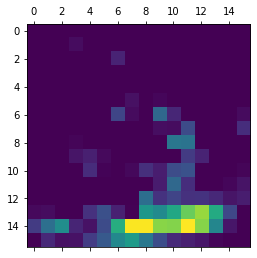

In [ ]:
# get the gradient of the output with respect to the parameters of the model
logits[:, 1].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(64):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze().cpu()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

Now, we can use OpenCV to interpolate the heat-map and project it onto the original image.

In [ ]:
import cv2
img = cv2.imread('/content/Test_CAM/data/automobile/car.jpg')
heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

Show the image

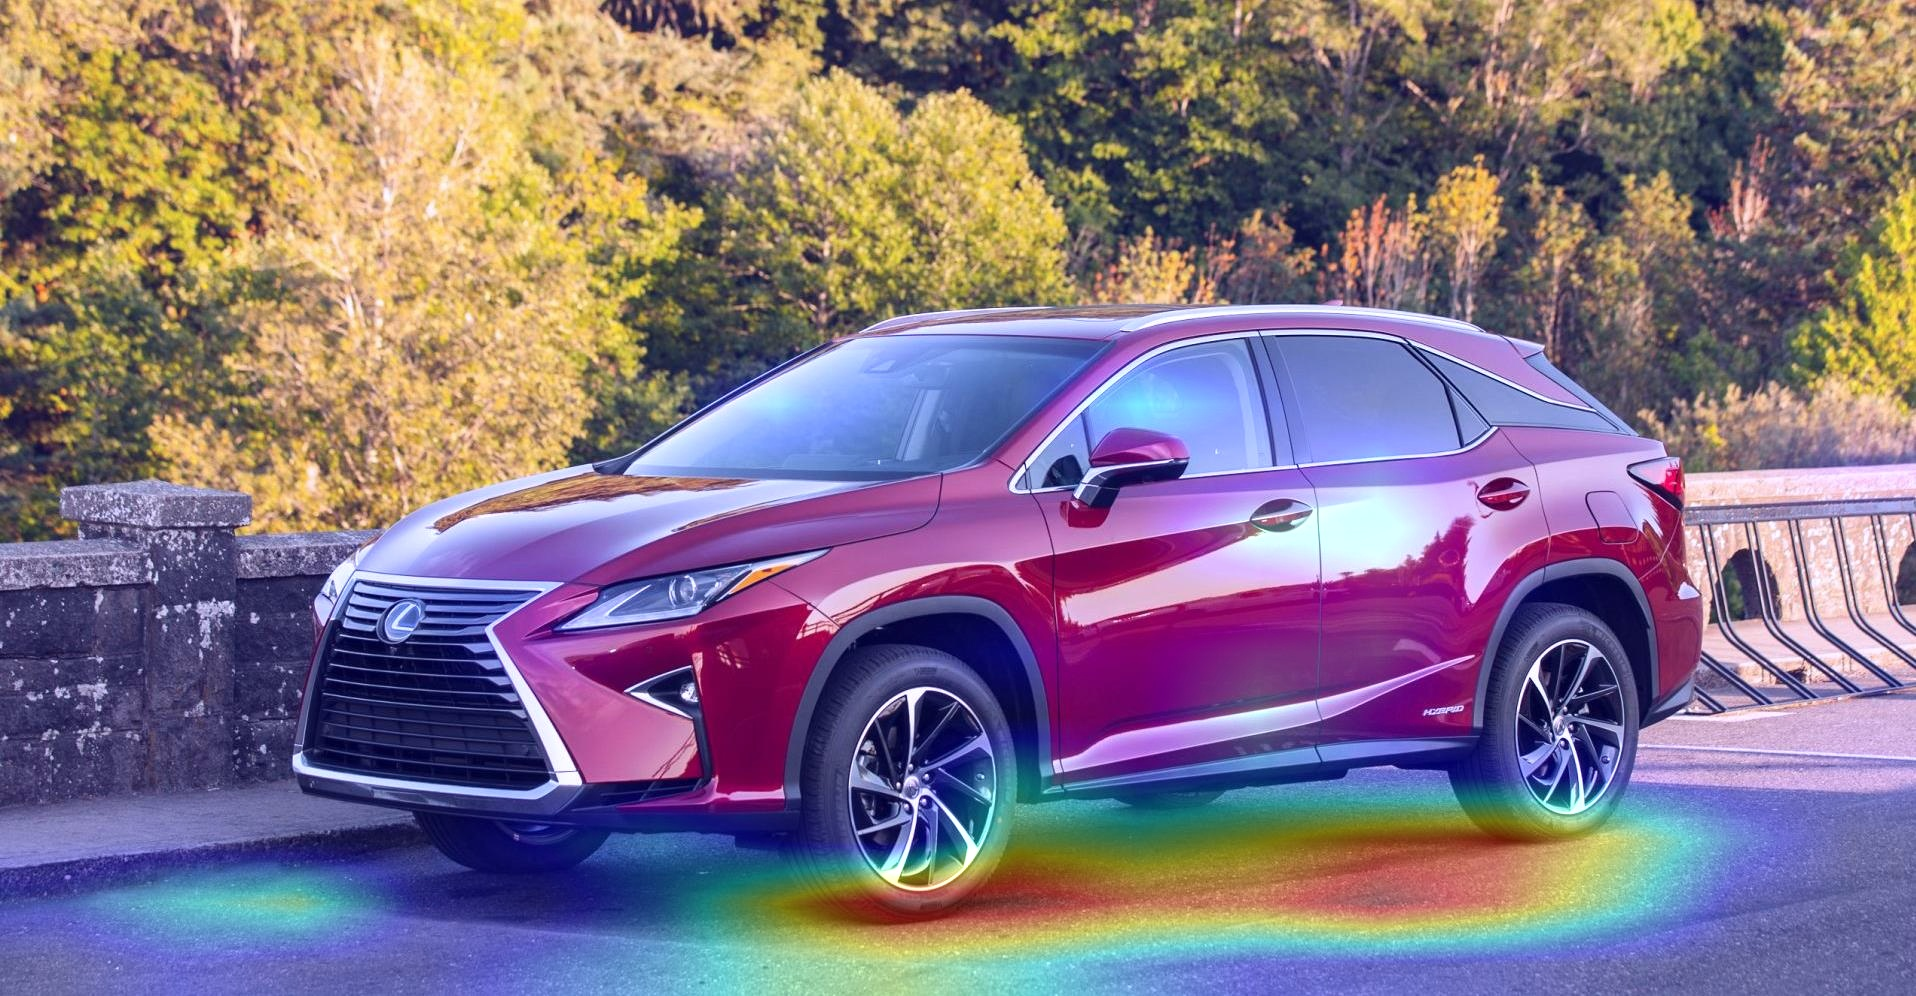

In [ ]:
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/map.jpg")
cv2_imshow(img)

## CheXpert Dataset


In [11]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                              title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
prasertk/healthy-lifestyle-cities-report-2021                    Healthy Lifestyle Cities Report 2021                 2KB  2022-03-03 00:26:02           1800         64  1.0              
piterfm/2022-ukraine-russian-war                                 2022 Ukraine Russia War                              1KB  2022-03-16 10:32:15           1428        116  1.0              
equinxx/spotify-top-50-songs-in-2021                             Spotify top 50 songs in 2021                         4KB  2022-03-09 08:46:59            772         32  1.0              
majyhain/height-of-male-an

In [12]:
!kaggle datasets download -d mimsadiislam/chexpert

100% 10.7G/10.7G [01:41<00:00, 178MB/s]
100% 10.7G/10.7G [01:41<00:00, 113MB/s]


In [13]:
!unzip chexpert.zip

Streaming output truncated to the last 5000 lines.
  inflating: CheXpert-v1.0-small/train/patient60445/study2/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60445/study2/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study2/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60446/study2/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60447/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60447/study1/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view2_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60448/study1/view3_lateral.jpg  
  inflating: CheXpert-v1.0-small/train/patient60449/study1/view1_frontal.jpg  
  inflating: CheXpert-v1.0-small/train/patient60449/study1/view2_lateral.jpg  
 

In [30]:
import numpy as np
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
from PIL import Image
from barbar import Bar

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score

use_gpu = torch.cuda.is_available()
print(use_gpu)

True


###Pre-Define value

In [31]:
# Paths to the files with training, and validation sets.
# Each file contains pairs (path to image, output vector)
Traindata = pd.read_csv('./CheXpert-v1.0-small/train.csv')
Traindata = Traindata[Traindata['Path'].str.contains("frontal")] # use only frontal images
Traindata = Traindata[500:]
Traindata.to_csv('./CheXpert-v1.0-small/train_mod.csv', index = False)
print("Train data length:", len(Traindata))

Validdata = pd.read_csv('./CheXpert-v1.0-small/valid.csv')
Validdata = Validdata[Validdata['Path'].str.contains("frontal")] # use only frontal images
Validdata.to_csv('./CheXpert-v1.0-small/valid_mod.csv', index = False)
print("Valid data length:", len(Validdata))

Testdata = Traindata.head(500) # use first 500 training data as test data (obs ratio is almost same!)
Testdata.to_csv('./CheXpert-v1.0-small/test_mod.csv', index = False)
print("Test data length:", len(Testdata))

pathFileTrain = './CheXpert-v1.0-small/train_mod.csv'
pathFileValid = './CheXpert-v1.0-small/valid_mod.csv'
pathFileTest = './CheXpert-v1.0-small/test_mod.csv'

# Neural network parameters:
nnIsTrained = False     # pre-trained using ImageNet
nnClassCount = 14       # dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 16
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

Train data length: 190527
Valid data length: 202
Test data length: 500


###Create a Dataset

In [32]:
class CheXpertDataSet(Dataset):
    def __init__(self, data_PATH, transform = None, policy = "ones"):
        """
        data_PATH: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels.
        """
        image_names = []
        labels = []

        with open(data_PATH, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None) # skip the header
            for line in csvReader:
                image_name = line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('./' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

###Load Datasets

In [33]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]  # mean of ImageNet dataset(for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]   # std of ImageNet dataset(for normalization)

# Tranform data
normalize = transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD)
transformList = []

transformList.append(transforms.Resize((imgtransCrop, imgtransCrop))) # 224
# transformList.append(transforms.RandomResizedCrop(imgtransCrop))
# transformList.append(transforms.RandomHorizontalFlip())
transformList.append(transforms.ToTensor())
# transformList.append(normalize)
transformSequence = transforms.Compose(transformList)

# Load dataset
datasetTrain = CheXpertDataSet(pathFileTrain, transformSequence, policy = "ones")
print("Train data length:", len(datasetTrain))

datasetValid = CheXpertDataSet(pathFileValid, transformSequence)
print("Valid data length:", len(datasetValid))

datasetTest = CheXpertDataSet(pathFileTest, transformSequence, policy = "ones")
print("Test data length:", len(datasetTest))


Train data length: 190527
Valid data length: 202
Test data length: 500


###Create Train and Test models

In [34]:
class CheXpertTrainer():

    def train(model, dataLoaderTrain, dataLoaderVal, nnClassCount, trMaxEpoch, checkpoint):
        optimizer = optim.Adam(model.parameters(), lr = 0.0001, # setting optimizer & scheduler
                               betas = (0.9, 0.999), eps = 1e-08, weight_decay = 0) 
        loss = torch.nn.BCELoss() # setting loss function
        
        if checkpoint != None and use_gpu: # loading checkpoint
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])
            optimizer.load_state_dict(modelCheckpoint['optimizer'])
            
        # Train the network
        lossMIN = 100000
        train_start = []
        train_end = []
        for epochID in range(0, trMaxEpoch):
            train_start.append(time.time()) # training starts
            losst = CheXpertTrainer.epochTrain(model, dataLoaderTrain, optimizer, trMaxEpoch, nnClassCount, loss)
            train_end.append(time.time()) # training ends
            lossv = CheXpertTrainer.epochVal(model, dataLoaderVal, optimizer, trMaxEpoch, nnClassCount, loss)
            print("Training loss: {:.3f},".format(losst), "Valid loss: {:.3f}".format(lossv))
            
            if lossv < lossMIN:
                lossMIN = lossv
                torch.save({'epoch': epochID + 1, 'state_dict': model.state_dict(), 
                            'best_loss': lossMIN, 'optimizer' : optimizer.state_dict()}, 
                           'm-epoch_FL' + str(epochID + 1) + '.pth.tar')
                print('Epoch ' + str(epochID + 1) + ' [save] loss = ' + str(lossv))
            else:
                print('Epoch ' + str(epochID + 1) + ' [----] loss = ' + str(lossv))

        train_time = np.array(train_end) - np.array(train_start)
        print("Training time for each epoch: {} seconds".format(train_time.round(0)))
        params = model.state_dict()
        return params
       
        
    def epochTrain(model, dataLoaderTrain, optimizer, epochMax, classCount, loss):
        losstrain = 0
        model.train()

        for batchID, (varInput, target) in enumerate(Bar(dataLoaderTrain)):
            
            varTarget = target.cuda(non_blocking = True)
            varOutput = model(varInput)
            lossvalue = loss(varOutput, varTarget)
                       
            optimizer.zero_grad()
            lossvalue.backward()
            optimizer.step()
            
            losstrain += lossvalue.item()
            
        return losstrain / len(dataLoaderTrain)
    
    
    def epochVal(model, dataLoaderVal, optimizer, epochMax, classCount, loss):
        model.eval()
        lossVal = 0

        with torch.no_grad():
            for i, (varInput, target) in enumerate(dataLoaderVal):
                
                target = target.cuda(non_blocking = True)
                varOutput = model(varInput)
                
                lossVal += loss(varOutput, target)
                
        return lossVal / len(dataLoaderVal)

    
    def computeAUROC(dataGT, dataPRED, classCount):
        # Computes area under ROC curve 
        # dataGT: ground truth data
        # dataPRED: predicted data
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()
        
        for i in range(classCount):
            try:
                outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
            except ValueError:
                pass
        return outAUROC
    
    
    def test(model, dataLoaderTest, nnClassCount, checkpoint, class_names):
        cudnn.benchmark = True
        
        if checkpoint != None and use_gpu:
            modelCheckpoint = torch.load(checkpoint)
            model.load_state_dict(modelCheckpoint['state_dict'])

        if use_gpu:
            outGT = torch.FloatTensor().cuda()
            outPRED = torch.FloatTensor().cuda()
        else:
            outGT = torch.FloatTensor()
            outPRED = torch.FloatTensor()
       
        model.eval()
        
        with torch.no_grad():
            for i, (input, target) in enumerate(dataLoaderTest):

                target = target.cuda()
                outGT = torch.cat((outGT, target), 0).cuda()

                bs, c, h, w = input.size()
                varInput = input.view(-1, c, h, w)
            
                out = model(varInput)
                outPRED = torch.cat((outPRED, out), 0)
        aurocIndividual = CheXpertTrainer.computeAUROC(outGT, outPRED, nnClassCount)
        aurocMean = np.array(aurocIndividual).mean()
        print('AUROC mean ', aurocMean)
        
        for i in range (0, len(aurocIndividual)):
            print(class_names[i], ' ', aurocIndividual[i])
        
        return outGT, outPRED

###Define the model

In [35]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

###Train the model with Federated Learning

In [41]:
# FOR MULTIPLE COMMUNICATION ROUNDS
com_round = 2
fraction = 1.0
epoch = 2
batch = 48
num_clients = 2

'''
# Divide datasetTrain_ex
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5, dataleft = random_split(datasetTrain, 
                                                                                                        [100, 100, 100, 100, 100,
                                                                                                         len(datasetTrain) - 500])
'''
# Divide datasetTrain_real
datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5 = random_split(datasetTrain, 
                                                                                              [38106, 38106, 38105, 38105, 38105])


# Define 5 DataLoaders
dataLoaderTrain_1 = DataLoader(dataset = datasetTrain_1, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_2 = DataLoader(dataset = datasetTrain_2, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_3 = DataLoader(dataset = datasetTrain_3, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_4 = DataLoader(dataset = datasetTrain_4, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)
dataLoaderTrain_5 = DataLoader(dataset = datasetTrain_5, batch_size = trBatchSize,
                               shuffle = True, num_workers = 2, pin_memory = True)

# Define Valid and Test DataLoaders
dataLoaderVal = DataLoader(dataset = datasetValid, batch_size = trBatchSize, 
                           shuffle = False, num_workers = 2, pin_memory = True)
dataLoaderTest = DataLoader(dataset = datasetTest, num_workers = 2, pin_memory = True)

In [42]:
dT = [datasetTrain_1, datasetTrain_2, datasetTrain_3, datasetTrain_4, datasetTrain_5]
dLT = [dataLoaderTrain_1, dataLoaderTrain_2, dataLoaderTrain_3, dataLoaderTrain_4, dataLoaderTrain_5]

model = DenseNet121(nnClassCount).cuda() # Step 0: Initialize global model and load the model
model = torch.nn.DataParallel(model).cuda()

for i in range(com_round):
    print("[[[ Round {} Start ]]]".format(i + 1))
    params = [None] * num_clients
    sel_clients = sorted(random.sample(range(num_clients), 
                                       round(num_clients*fraction))) # Step 1: select random fraction of clients
    print("The number of clients:", len(sel_clients))
    for j in sel_clients: # Step 2: send weights to clients
        print("<< Client {} Training Start >>".format(j + 1))
        train_valid_start = time.time()
        params[j] = CheXpertTrainer.train(model, dLT[j], dataLoaderVal, # Step 3: Perform local computations
                                          nnClassCount, trMaxEpoch = epoch, checkpoint = None)
        train_valid_end = time.time()
        client_time = round(train_valid_end - train_valid_start)
        print("<< Client {} Training End: {} seconds elapsed >>".format(j + 1, client_time))
        
    fidx = [idx for idx in range(len(params)) if params[idx] != None][0]
    lidx = [idx for idx in range(len(params)) if params[idx] != None][-1]
    for key in params[fidx]: # Step 4: return updates to server
        weights, weightn = [], []
        for k in sel_clients:
            weights.append(params[k][key]*len(dT[k]))
            weightn.append(len(dT[k]))
        params[lidx][key] = sum(weights) / sum(weightn) # weighted averaging model weights

    model = DenseNet121(nnClassCount).cuda()
    model = torch.nn.DataParallel(model).cuda()
    model.load_state_dict(params[lidx]) # Step 5: server updates global state
    print("[[[ Round {} End ]]]".format(i + 1))
    
print("Global model trained")


[[[ Round 1 Start ]]]
The number of clients: 2
<< Client 1 Training Start >>
38106/38106: [===============================>] - ETA 0.8s
Training loss: 0.398, Valid loss: 0.424
Epoch 1 [save] loss = tensor(0.4241, device='cuda:0')
38106/38106: [===============================>] - ETA 0.6s
Training loss: 0.380, Valid loss: 0.416
Epoch 2 [save] loss = tensor(0.4159, device='cuda:0')
Training time for each epoch: [1071. 1069.] seconds
<< Client 1 Training End: 2144 seconds elapsed >>
<< Client 2 Training Start >>
38106/38106: [===============================>] - ETA 0.7s
Training loss: 0.378, Valid loss: 0.387
Epoch 1 [save] loss = tensor(0.3871, device='cuda:0')
38106/38106: [===============================>] - ETA 0.6s
Training loss: 0.370, Valid loss: 0.386
Epoch 2 [save] loss = tensor(0.3863, device='cuda:0')
Training time for each epoch: [1065. 1068.] seconds
<< Client 2 Training End: 2137 seconds elapsed >>
[[[ Round 1 End ]]]
[[[ Round 2 Start ]]]
The number of clients: 2
<< Client 

###Test and ROC Curves


In [43]:
outGT, outPRED = CheXpertTrainer.test(model, dataLoaderTest, nnClassCount, None, class_names)

AUROC mean  0.7847304663079961
No Finding   0.8760212418300654
Enlarged Cardiomediastinum   0.6659151754262365
Cardiomegaly   0.876753300330033
Lung Opacity   0.7483294025157233
Lung Lesion   0.715352158390133
Edema   0.8435838556858851
Consolidation   0.7484271864686469
Pneumonia   0.7229280850357083
Atelectasis   0.7311823671256902
Pneumothorax   0.8312893387839855
Pleural Effusion   0.8847833333333331
Pleural Other   0.7698625809508767
Fracture   0.7466945024356297
Support Devices   0.8251040000000001


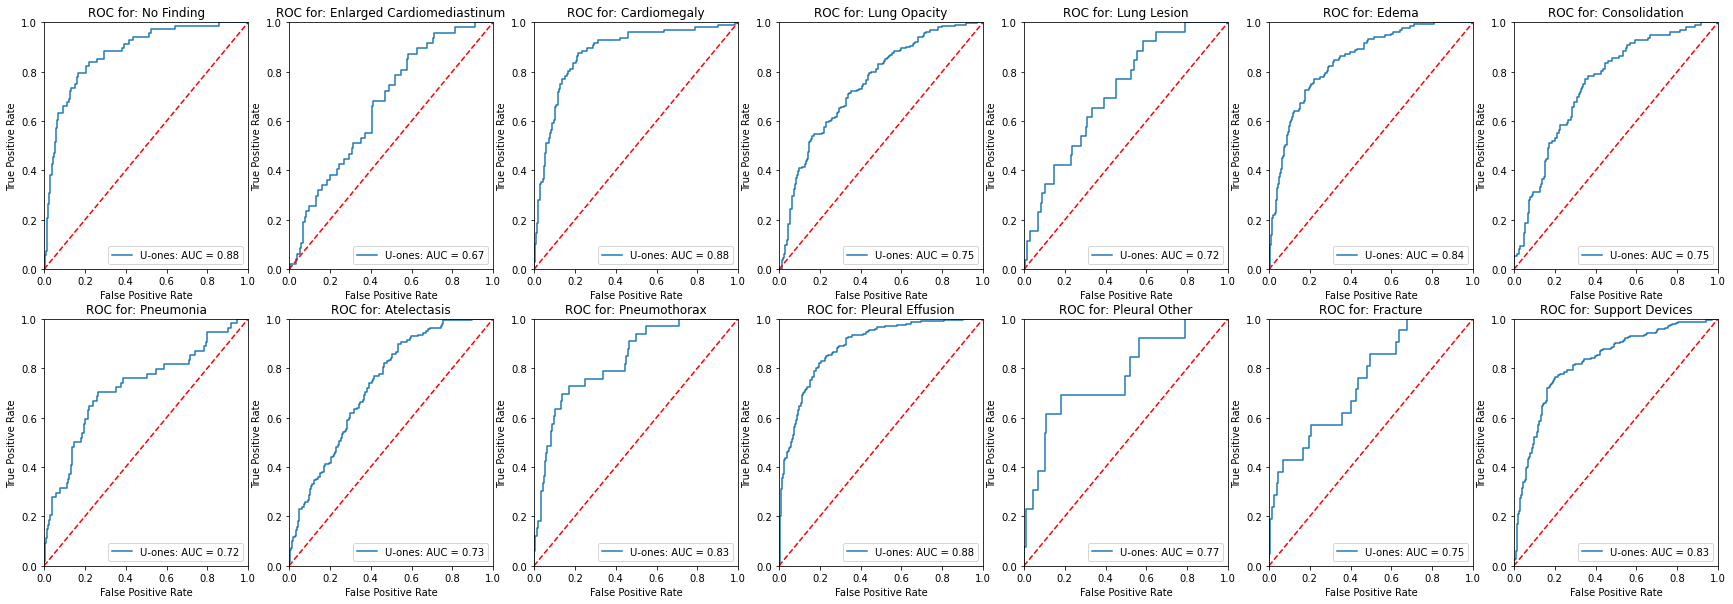

In [45]:
for i in range(nnClassCount):
    fpr, tpr, threshold = metrics.roc_curve(outGT.cpu()[:,i], outPRED.cpu()[:,i])
    roc_auc = metrics.auc(fpr, tpr)
    f = plt.subplot(2, 7, i+1)

    plt.title('ROC for: ' + class_names[i])
    plt.plot(fpr, tpr, label = 'U-ones: AUC = %0.2f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = (90, 30)

plt.savefig("ROC.png", dpi = 1000)
plt.show()

##Grad-CAM CheXpert

In [46]:
import random
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms

from PIL import Image

import cv2

In [47]:
# path to the folder with chexpert dataset which has structure outlined in the project description
data_path = '/content/CheXpert-v1.0-small'

train_csv_path = data_path + '/train_mod.csv'
valid_csv_path = data_path + '/valid_mod.csv'
test_csv_path = data_path + '/test_mod.csv'
dir_path = data_path

#path to the directory with saved state dictionaries
model_save_dir = '/content/Results CheXpert'



###Data Preparation

In [48]:
def dropper(df):
    d = df.copy()
    index = d[d["Frontal/Lateral"] == "Lateral"].index
    d.drop(index=index, axis=0, inplace=True)
    d = d.drop(columns=['Sex','Age','Frontal/Lateral','AP/PA'])
    num = d._get_numeric_data()
    num[num < 0] = 1 # U-ones policy
    # d.Path = d.Path.str.replace('CheXpert-','chexpert/')
    d = d.reset_index(drop=True)
    return d

In [49]:
valid_csv = pd.read_csv(valid_csv_path, sep=',').fillna(0)
dval = dropper(valid_csv)

train_csv = pd.read_csv(train_csv_path, sep=',').fillna(0)
dtrain = dropper(train_csv)

test_csv = pd.read_csv(test_csv_path, sep=',').fillna(0)
dtest = dropper(test_csv)

# image paths as Series
vpath = dval.Path
tpath = dtrain.Path
ttpath = dtest.Path

###Transforms

In [50]:
# efficientnet transform
efnet_transform = transforms.Compose([
    transforms.Resize((456, 456)),
    transforms.ToTensor(),
])

# densenet transform
dnet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [51]:
def findings(z, beta=0.5):

    # assume z is a tensor 
    if type(z) != np.ndarray:
        y = z.squeeze().numpy()
        #print('shape',y.shape)
    else:
        y = z.copy().squeeze()
        #print(y)

    idx = np.argwhere(y > beta)

    if idx.ndim > 1:
        idx = idx.squeeze()

    if idx.ndim == 0:
        idx = np.expand_dims(idx,0)
    return idx

###Hooks

In [52]:
# gradients for gradcam are stored here
stored_grads = torch.Tensor([])
stored_fpass = torch.Tensor([])

def bpass_hook(self, gin, gout):
    global stored_grads
    stored_grads = gout

def fpass_hook(self, ten_in, ten_out):
    global stored_fpass
    stored_fpass = ten_out

###Load model

In [53]:
class DenseNet121(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained = False)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x


In [54]:
# Initialize and load the model
model = DenseNet121(14).cuda()
model = torch.nn.DataParallel(model).cuda()

In [57]:
def select(n=0):
    global model, transform
    
    if n==0:
        # Load the DenseNet121 
        # model = torchvision.models.densenet121()
        model = DenseNet121(14).cuda() ################# gpu
        model = torch.nn.DataParallel(model).cuda() ################# gpu
        # Get the input dimension of last layer
        # kernel_count = model.classifier.in_features
        # Replace last layer with new layer that have num_classes nodes, after that apply Sigmoid to the output
        # model.classifier = nn.Sequential(nn.Linear(kernel_count, 14), nn.Sigmoid())
        
        # name = 'epoch_1_score_0.81652.pth'
        # name = 'm-epoch_ALL3.pth.tar'
        name = 'm-epoch_FL2.pth.tar'
        model.load_state_dict(torch.load(os.path.join(model_save_dir, name))['state_dict'])
        _=model.eval()
        
        # Get module object of last conv layer to attach hook to it
        last_conv_layer = model.module.densenet121.features.denseblock4.denselayer16.conv2
        transform = dnet_transform

    if n==1:
        model = EfficientNet.from_pretrained('efficientnet-b5')
        model = nn.Sequential(nn.Linear(2048, 14), nn.Sigmoid())
        
        loaded_tuple = torch.load(model_save_dir+'epoch_3_score_0.88577.pth', map_location='cpu')
        state_dict = loaded_tuple['state_dict']

        # rename keys of state dict for efficient net
        keys = list(state_dict.keys())
        for k in keys:
            new_key = k[4:]
            state_dict[new_key] = state_dict.pop(k)
        
        model.load_state_dict(state_dict)
        _ = model.eval()
        
        last_conv_layer = model.net._conv_head
        transform = efnet_transform
    
    # register hooks for gradCAM
    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

In [58]:
select(0)

###Run Grad-CAM

In [60]:
correct_idx = []
incorrect_idx = []

for idx in range(500):
    imid = idx
    print('      ')
    print('      ')
    print('<<< Image #{} >>>'.format(idx + 1))
    path1 = './' + dtest.Path[imid]
    print('Path: {}'.format(path1))
    image_orig = Image.open(path1).convert('RGB')
    image_transformed = transform(image_orig).unsqueeze(0)

    true_labels_vec = dtest.iloc[imid,1:].to_numpy().astype(int)
    true_labels = np.argwhere(true_labels_vec==1).flatten()
    true_labels_uncertain = np.argwhere((-1)*true_labels_vec==1).flatten()
    
    # run model
    out = model(image_transformed).cpu()
    out_np = out.detach().numpy().squeeze()

    pred_labels_binary = findings(out_np)
    pred_labels_p = np.round(out_np[pred_labels_binary], 2)

    # generate arguments for backward() function corresponding to classes with p>0.5
    l = len(pred_labels_binary)
    args = []
    for ii in pred_labels_binary:
        backward_arg = torch.zeros(1,14)
        backward_arg[0,ii] = 1
        args.append(backward_arg)
    
    # generate gradCAMs
    hmap_list = []
    cam_list = []

    img_hmap = np.transpose(image_transformed.squeeze().numpy(),(1,2,0))

    # plot
    arglen = len(args)
    kwargs = dict(xticks=[],yticks=[])

    # fig, ax = plt.subplots(1, arglen, figsize=(5*arglen,5), subplot_kw=kwargs)
    # if arglen==1:
        # ax = [ax]
    # plt.subplots_adjust(wspace=0.1, hspace=0.1)

    for k, a in enumerate(args):
        print('{}/{}'.format(k+1,arglen))
        out.backward(a, retain_graph=True)

        gradients = stored_grads[0].clone()
        activations = stored_fpass[0].clone().unsqueeze(0)
        activations = activations.detach()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

        for j in range(gradients.shape[1]):
            activations[:, j, :, :] *= pooled_gradients[j]

        heatmap = torch.sum(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        hmap_list.append(heatmap)
    
        #ax.flatten()[k].imshow(heatmap)
    

        hmap = heatmap.numpy()
        heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
        heatmap1 = np.uint8(-255 * heatmap1 + 255)
        heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

        supim = heatmap1 * 0.002 + img_hmap
        supim = supim / supim.max()
    
        cam_list.append(supim)
    
        #ax[k].imshow(supim)
        #ax[k].set_title(dtrain.columns[1:][pred_labels_binary[k]])
        
    GT = dtest.columns[1:][true_labels].to_list()
    PRED = dtest.columns[1:][pred_labels_binary].to_list()
    result = all(elem in GT for elem in PRED)
    
    if result:
        correct_idx.append(idx)
    else:
        incorrect_idx.append(idx)

    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('True labels:', true_labels, dtest.columns[1:][true_labels].to_list())
    print('Uncertainties:', true_labels_uncertain, dtest.columns[1:][true_labels_uncertain].to_list())
    print('Prediction:', pred_labels_binary, dtest.columns[1:][pred_labels_binary].to_list())
    print('Probabilities:', pred_labels_p)

      
      
<<< Image #1 >>>
Path: ./CheXpert-v1.0-small/train/patient00147/study13/view1_frontal.jpg
1/2
2/2


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Streaming output truncated to the last 5000 lines.
True labels: [ 5 13] ['Edema', 'Support Devices']
Uncertainties: [] []
Prediction: [13] ['Support Devices']
Probabilities: [0.82]
      
      
<<< Image #30 >>>
Path: ./CheXpert-v1.0-small/train/patient00155/study5/view1_frontal.jpg
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3] ['Lung Opacity']
Uncertainties: [] []
Prediction: [] []
Probabilities: []
      
      
<<< Image #31 >>>
Path: ./CheXpert-v1.0-small/train/patient00156/study1/view1_frontal.jpg
1/2
2/2
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  5  7 13] ['Lung Opacity', 'Edema', 'Pneumonia', 'Support Devices']
Uncertainties: [] []
Prediction: [ 3 10] ['Lung Opacity', 'Pleural Effusion']
Probabilities: [0.58 0.65]
      
      
<<< Image #32 >>>
Path: ./CheXpert-v1.0-small/train/patient00157/study1/view1_frontal.jpg
1/3
2/3
3/3
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [ 3  4  5 10] ['Lun

In [61]:
print(correct_idx)
print(incorrect_idx)

[0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 17, 18, 19, 20, 21, 22, 24, 25, 26, 28, 29, 31, 33, 35, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 70, 78, 81, 83, 84, 87, 90, 91, 92, 93, 94, 96, 97, 103, 104, 105, 107, 108, 111, 112, 113, 118, 120, 121, 122, 123, 124, 128, 129, 130, 131, 132, 133, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 149, 150, 151, 152, 156, 157, 160, 161, 162, 163, 165, 166, 167, 168, 169, 171, 172, 173, 174, 176, 178, 179, 180, 181, 182, 183, 184, 187, 188, 189, 190, 192, 193, 194, 195, 198, 202, 203, 206, 207, 208, 209, 210, 212, 213, 214, 215, 216, 219, 222, 230, 231, 232, 233, 234, 236, 238, 239, 240, 241, 242, 248, 249, 252, 253, 255, 256, 258, 262, 266, 268, 270, 273, 274, 278, 279, 280, 281, 282, 283, 284, 285, 287, 290, 291, 292, 294, 296, 298, 299, 301, 302, 306, 308, 309, 313, 314, 317, 318, 319, 321, 322, 323, 324, 325, 327, 328, 332, 334, 337, 338, 340, 341, 342, 343, 344, 346, 348, 34

      
      
<<< Image #384 >>>
Path: ./CheXpert-v1.0-small/train/patient00269/study1/view1_frontal.jpg
1/2
2/2


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True labels: [3 6] ['Lung Opacity', 'Consolidation']
Uncertainties: [] []
Prediction: [ 3 10] ['Lung Opacity', 'Pleural Effusion']
Probabilities: [0.6  0.68]


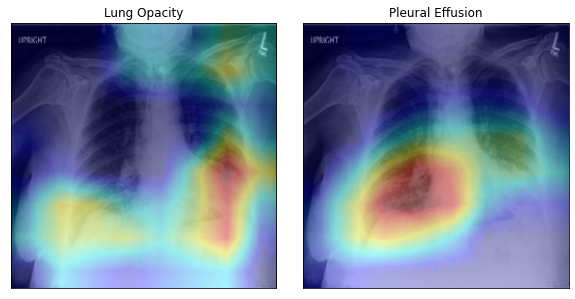

In [62]:
# get image and true labels
imid = 383
print('      ')
print('      ')
print('<<< Image #{} >>>'.format(imid + 1))

path1 = './' + dtest.Path[imid]

print('Path: {}'.format(path1))

image_orig = Image.open(path1).convert('RGB')
image_transformed = transform(image_orig).unsqueeze(0)

true_labels_vec = dtest.iloc[imid,1:].to_numpy().astype(int)
true_labels = np.argwhere(true_labels_vec==1).flatten()
true_labels_uncertain = np.argwhere((-1)*true_labels_vec==1).flatten()

# run model
out = model(image_transformed).cpu()
out_np = out.detach().numpy().squeeze()

pred_labels_binary = findings(out_np)
pred_labels_p = np.round(out_np[pred_labels_binary], 2)

# generate arguments for backward() function corresponding to classes with p>0.5
l = len(pred_labels_binary)
args = []
for ii in pred_labels_binary:
    backward_arg = torch.zeros(1,14)
    backward_arg[0,ii] = 1
    args.append(backward_arg)
    
# generate gradCAMs
hmap_list = []
cam_list = []

img_hmap = np.transpose(image_transformed.squeeze().numpy(),(1,2,0))

# plot
arglen = len(args)
kwargs = dict(xticks=[],yticks=[])

fig, ax = plt.subplots(1, arglen, figsize=(5*arglen,5), subplot_kw=kwargs)
if arglen==1:
    ax = [ax]
plt.subplots_adjust(wspace=0.1, hspace=0.1)

for k, a in enumerate(args):
    print('{}/{}'.format(k+1,arglen))
    out.backward(a, retain_graph=True)

    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    activations = activations.detach()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    for j in range(gradients.shape[1]):
        activations[:, j, :, :] *= pooled_gradients[j]

    heatmap = torch.sum(activations, dim=1).squeeze().cpu()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)

    hmap_list.append(heatmap)
    
    #ax.flatten()[k].imshow(heatmap)
    

    hmap = heatmap.numpy()
    heatmap1 = cv2.resize(hmap, (img_hmap.shape[1], img_hmap.shape[0]))
    heatmap1 = np.uint8(-255 * heatmap1 + 255)
    heatmap1 = cv2.applyColorMap(heatmap1, cv2.COLORMAP_JET)

    supim = heatmap1 * 0.002 + img_hmap
    supim = supim / supim.max()
    
    cam_list.append(supim)
    
    ax[k].imshow(supim)
    ax[k].set_title(dtest.columns[1:][pred_labels_binary[k]])

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('True labels:', true_labels, dtest.columns[1:][true_labels].to_list())
print('Uncertainties:', true_labels_uncertain, dtest.columns[1:][true_labels_uncertain].to_list())
print('Prediction:', pred_labels_binary, dtest.columns[1:][pred_labels_binary].to_list())
print('Probabilities:', pred_labels_p)

###Original image

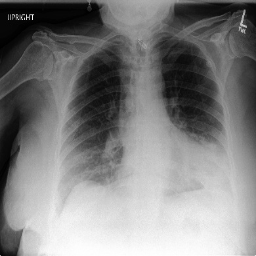

In [69]:
from google.colab.patches import cv2_imshow


imgOriginal = cv2.imread('./CheXpert-v1.0-small/train/patient00269/study1/view1_frontal.jpg', 1)
imgOriginal = cv2.resize(imgOriginal, (256, 256))
cv2_imshow(imgOriginal)
#plt.imshow(imgOriginal)
#plt.plot()
#plt.axis('off')
#plt.show()

In [70]:
# Download results
!zip -r /content/Results_CheXpert.zip /content/Results_CheXpert

from google.colab import files
files.download("/content/Results_CheXpert.zip")

  adding: content/Results_CheXpert/ (stored 0%)
  adding: content/Results_CheXpert/m-epoch_FL2.pth.tar (deflated 9%)
  adding: content/Results_CheXpert/ROC.png (deflated 38%)
  adding: content/Results_CheXpert/m-epoch_FL1.pth.tar (deflated 9%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>